In [ ]:
import os
import sys
sys.path.append(os.path.join('..', '..'))

from scripts.data_loaders.common import show_sample, TARGET_SAMPLE_RATE
from scripts.ipa_transcription.wav2vec2 import transcribe_batch_timestamped
from scripts.core.audio import audio_array_to_wav_file, audio_bytes_to_wav_array
from scripts.core.codes import arpabet2ipa
from scripts.forced_alignment.needleman_wunsch import weighted_needleman_wunsch, needleman_wunsch
from scripts.forced_alignment.dtw import dtw_phoneme_alignment, dtw_phoneme_alignment_weighted
from scripts.eval.evaluate import simplify_ipa

import torch
from transformers import AutoProcessor, AutoModelForCTC

from g2p_en import G2p

import pandas as pd
import zipfile
from string import punctuation

from IPython.display import clear_output
clear_output()

# Load Data

In [2]:
DATA_ZIP = os.path.join('..', '.data', 'speech-accent-snake-snack.zip')

In [3]:
with zipfile.ZipFile(DATA_ZIP, 'r') as zip_ref:
    with zip_ref.open('reading-passage.txt') as f:
        text = f.read().decode('utf-8')
    with zip_ref.open('speakers_all.csv') as f:
        speakers = pd.read_csv(f)
print(text)
display(speakers.head())

Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.



,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [4]:
with zipfile.ZipFile(DATA_ZIP, 'r') as zip_ref:
    RECORDINGS = [f for f in zip_ref.namelist() if f.endswith('.mp3')]
print(f'Found {len(RECORDINGS)} recordings')

Found 2138 recordings


IPA: Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.



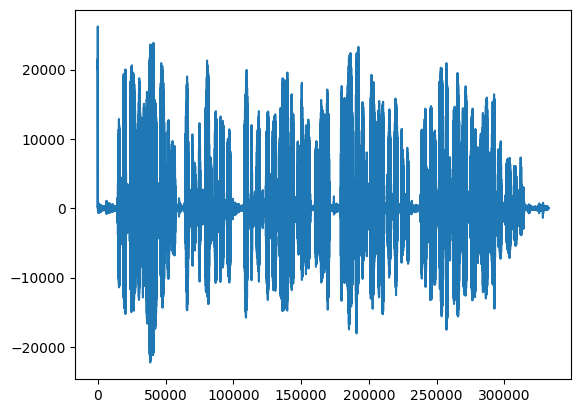

In [5]:
def get_sample(index):
    with zipfile.ZipFile(DATA_ZIP, 'r') as zip_ref:
        recording = RECORDINGS[index]

        with zip_ref.open(recording) as f:
            audio = audio_bytes_to_wav_array(f.read(), 'mp3', TARGET_SAMPLE_RATE)
            clear_output()
            return (text, audio)
show_sample(get_sample(0))

# Formulate algorithm to automatically transcribe specific words with and without context

In [6]:
MODEL_ID = 'facebook/wav2vec2-lv-60-espeak-cv-ft'
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
torch.mps.empty_cache()
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = AutoModelForCTC.from_pretrained(MODEL_ID).to(DEVICE)

In [7]:
sample = get_sample(0)
transcription, timestamped_phonemes = transcribe_batch_timestamped([sample], model, processor)
print(transcription)
print(timestamped_phonemes)

['p l iː s k oʊ l s t ɛ l ɚ ɑː s k ɚ t ə b ɹ ɪ ŋ ð iː z θ ɪ ŋ z w ɪ v h ɚ f ɹ ʌ m ð ə s t oʊ s ɪ k s p uː n z ʌ v f ɹ iː s n oʊ p iː s f aɪ v θ ɪ k s l æ p s ʌ v b l uː tʃ iː z æ n d m eɪ b i s n æ k f ɔːɹ h ɜː b ɹ ʌ ð ɚ ɚ b ɹ æ ð ɚ b ɔ b w iː ɔː l s oʊ n iː d ɐ s m oʊ l p l æ s t ɪ k s n eɪ k æ n d ɐ b ɪ ɡ t uː f ɹ ɔ k f ɔːɹ ð ə k ɪ d z ʃ iː k æ n s k uː p ð iː z θ ɪ ŋ z ɪ n t ʊ f ɹ iː ɹ ɹ iː t b æ k s æ n w iː w ɪ l ɡ oʊ m iː ɾ ɐ w ɪ n s t eɪ æ t ə d ɹ eɪ n s t eɪ ʃ ə n']
[[('p', 0.8806616939364774, 0.9006767324350338), ('l', 0.92069177093359, 0.9407068094321464), ('i ː', 0.9607218479307026, 0.9807368864292589), ('s', 1.0407820019249279, 1.060797040423484), ('k', 1.1408571944177095, 1.1608722329162657), ('o ʊ', 1.180887271414822, 1.2009023099133782), ('l', 1.2609474254090471, 1.30097750240616), ('s', 1.3610226179018288, 1.3810376564003852), ('t', 1.4610978103946104, 1.4811128488931666), ('ɛ', 1.521142925890279, 1.5411579643888356), ('l', 1.641233156881617, 1.6612481953801732), ('ɚ', 

In [8]:
g2p = G2p()

def text2ipa(text):
    arpa = g2p(text)
    ipa = ''.join(map(arpabet2ipa, arpa))
    return ipa

TEXT = text.translate(str.maketrans('', '', punctuation))
WORDS = TEXT.split()
IPAS = [(word, text2ipa(word)) for word in WORDS]
IPA = ''.join([ipa for _, ipa in IPAS])
print(IPAS)
print(IPA)

[('Please', 'pliˈz'), ('call', 'kɔˈl'), ('Stella', 'stɛˈlʌ'), ('Ask', 'æˈsk'), ('her', 'hɝ'), ('to', 'tuˈ'), ('bring', 'bɹɪˈŋ'), ('these', 'ðiˈz'), ('things', 'θɪˈŋz'), ('with', 'wɪˈð'), ('her', 'hɝ'), ('from', 'fɹʌˈm'), ('the', 'ðʌ'), ('store', 'stɔˈɹ'), ('Six', 'sɪˈks'), ('spoons', 'spuˈnz'), ('of', 'ʌˈv'), ('fresh', 'fɹɛˈʃ'), ('snow', 'snoʊˈ'), ('peas', 'piˈz'), ('five', 'faɪˈv'), ('thick', 'θɪˈk'), ('slabs', 'slæˈbz'), ('of', 'ʌˈv'), ('blue', 'bluˈ'), ('cheese', 'tʃiˈz'), ('and', 'ʌnd'), ('maybe', 'meɪˈbi'), ('a', 'ʌ'), ('snack', 'snæˈk'), ('for', 'fɔˈɹ'), ('her', 'hɝ'), ('brother', 'bɹʌˈðɝ'), ('Bob', 'bɑˈb'), ('We', 'wiˈ'), ('also', 'ɔˈlsoʊ'), ('need', 'niˈd'), ('a', 'ʌ'), ('small', 'smɔˈl'), ('plastic', 'plæˈstɪk'), ('snake', 'sneɪˈk'), ('and', 'ʌnd'), ('a', 'ʌ'), ('big', 'bɪˈɡ'), ('toy', 'tɔɪˈ'), ('frog', 'fɹɑˈɡ'), ('for', 'fɔˈɹ'), ('the', 'ðʌ'), ('kids', 'kɪˈdz'), ('She', 'ʃiˈ'), ('can', 'kæˈn'), ('scoop', 'skuˈp'), ('these', 'ðiˈz'), ('things', 'θɪˈŋz'), ('into', 'ɪntuˈ'), ('t

In [9]:
al1, al2 = needleman_wunsch(simplify_ipa(IPA), simplify_ipa(transcription[0]))
print(al1)
print(al2)

['p', 'l', 'i', 'z', 'k', '-', 'ɔ', 'l', 's', 't', 'ɛ', 'l', 'ʌ', 'æ', 's', 'k', 'h', 'ɝ', 't', 'u', 'b', 'ɹ', 'ɪ', 'ŋ', 'ð', 'i', 'z', 'θ', 'ɪ', 'ŋ', 'z', 'w', 'ɪ', 'ð', 'h', 'ɝ', 'f', 'ɹ', 'ʌ', 'm', 'ð', 'ʌ', 's', 't', 'ɔ', 'ɹ', 's', 'ɪ', 'k', 's', 's', 'p', 'u', 'n', 'z', 'ʌ', 'v', 'f', 'ɹ', 'ɛ', 'ʃ', 's', 'n', 'o', 'ʊ', 'p', 'i', 'z', 'f', 'a', 'ɪ', 'v', 'θ', 'ɪ', 'k', 's', 'l', 'æ', 'b', 'z', 'ʌ', 'v', 'b', 'l', 'u', 't', 'ʃ', 'i', 'z', 'ʌ', 'n', 'd', 'm', 'e', 'ɪ', 'b', 'i', 'ʌ', 's', 'n', 'æ', 'k', 'f', 'ɔ', 'ɹ', 'h', 'ɝ', 'b', 'ɹ', 'ʌ', '-', '-', '-', '-', '-', '-', 'ð', 'ɝ', 'b', 'ɑ', 'b', 'w', 'i', 'ɔ', 'l', 's', 'o', 'ʊ', 'n', 'i', 'd', 'ʌ', 's', 'm', '-', 'ɔ', 'l', 'p', 'l', 'æ', 's', 't', 'ɪ', 'k', 's', 'n', 'e', 'ɪ', 'k', 'ʌ', 'n', 'd', 'ʌ', 'b', 'ɪ', 'ɡ', 't', 'ɔ', 'ɪ', 'f', 'ɹ', 'ɑ', 'ɡ', 'f', 'ɔ', 'ɹ', 'ð', 'ʌ', 'k', 'ɪ', 'd', 'z', 'ʃ', 'i', 'k', 'æ', 'n', 's', 'k', 'u', 'p', 'ð', 'i', 'z', 'θ', 'ɪ', 'ŋ', 'z', 'ɪ', 'n', 't', 'u', 'θ', 'ɹ', 'i', '-', 'ɹ', 'ɛ', 'd', 'b',

In [10]:
al1, al2 = weighted_needleman_wunsch(simplify_ipa(IPA), simplify_ipa(transcription[0]))
print(al1)
print(al2)

['p', 'l', 'i', 'z', 'k', 'ɔ', '-', 'l', 's', 't', 'ɛ', 'l', 'ʌ', 'æ', 's', 'k', 'h', 'ɝ', 't', 'u', 'b', 'ɹ', 'ɪ', 'ŋ', 'ð', 'i', 'z', 'θ', 'ɪ', 'ŋ', 'z', 'w', 'ɪ', 'ð', 'h', 'ɝ', 'f', 'ɹ', 'ʌ', 'm', 'ð', 'ʌ', 's', 't', 'ɔ', 'ɹ', 's', 'ɪ', 'k', 's', 's', 'p', 'u', 'n', 'z', 'ʌ', 'v', 'f', 'ɹ', 'ɛ', 'ʃ', 's', 'n', 'o', 'ʊ', 'p', 'i', 'z', 'f', 'a', 'ɪ', 'v', 'θ', 'ɪ', 'k', 's', 'l', 'æ', 'b', 'z', 'ʌ', 'v', 'b', 'l', 'u', 't', 'ʃ', 'i', 'z', 'ʌ', 'n', 'd', 'm', 'e', 'ɪ', '-', '-', 'b', 'i', 'ʌ', 's', 'n', 'æ', 'k', '-', 'f', '-', 'ɔ', 'ɹ', 'h', 'ɝ', 'b', 'ɹ', 'ʌ', 'ð', 'ɝ', 'b', 'ɑ', 'b', 'w', 'i', 'ɔ', 'l', 's', 'o', 'ʊ', 'n', 'i', 'd', '-', 'ʌ', 's', 'm', 'ɔ', 'l', 'p', 'l', 'æ', 's', 't', 'ɪ', 'k', 's', 'n', 'e', 'ɪ', 'k', 'ʌ', 'n', 'd', 'ʌ', 'b', 'ɪ', 'ɡ', 't', 'ɔ', 'ɪ', 'f', 'ɹ', 'ɑ', 'ɡ', 'f', 'ɔ', 'ɹ', 'ð', 'ʌ', 'k', 'ɪ', 'd', 'z', 'ʃ', 'i', 'k', 'æ', 'n', 's', 'k', 'u', 'p', 'ð', 'i', 'z', 'θ', 'ɪ', 'ŋ', 'z', 'ɪ', 'n', 't', '-', 'u', 'θ', 'ɹ', 'i', 'ɹ', 'ɛ', 'd', 'b', 'æ', 'ɡ',

In [11]:
al1, al2 = dtw_phoneme_alignment(simplify_ipa(IPA), simplify_ipa(transcription[0]))
print(al1)
print(al2)

plizkkɔlstɛlʌæskhɝtubɹɪŋðizθɪŋzwɪðhɝfɹʌmðʌstɔɹsɪksspunzʌvfɹɛʃsnoʊpizfaɪvθɪkslæbzʌvblutʃizʌndmeɪbiiiiʌsnækfɔɹɹɹhɝbɹʌðɝbɑbwiɔlsoʊnidʌsmmɔlplæstɪksneɪkʌndʌbɪɡtɔɪfɹɑɡfɔɹðʌkɪdzʃikænskupðizθɪŋzɪntuθɹiɹɹɛdbæɡzʌndwiwɪlɡoʊmithɝwɛnnzdiætðʌtɹeɪnsteɪʃʌn
pliskoʊlstɛlɚɑskkɚtəbɹɪŋðizθɪŋzwɪvhɚfɹʌmðəstoʊsɪksspunzʌvfɹɹisnoʊpisfaɪvθɪkslæpsʌvblutʃizændmeɪbisnækfɔɹhɜbɹʌðɚɚbɹæðɚbɔbwiɔlsoʊnidɐsmoʊlplæstɪksneɪkændɐbɪɡttufɹɔkfɔɹðəkɪdzʃikænskupðizθɪŋzɪntʊfɹiɹɹitbæksænnwiwɪlɡoʊmiiɾɐwɪnsteɪættədɹeɪnsteɪʃən


In [12]:
al1, al2 = dtw_phoneme_alignment_weighted(simplify_ipa(IPA), simplify_ipa(transcription[0]))
print(al1)
print(al2)

['p', 'l', 'i', 'z', 'k', 'ɔ', 'ɔ', 'l', 's', 't', 'ɛ', 'l', 'ʌ', 'æ', 's', 'k', 'h', 'ɝ', 't', 'u', 'b', 'ɹ', 'ɪ', 'ŋ', 'ð', 'i', 'z', 'θ', 'ɪ', 'ŋ', 'z', 'w', 'ɪ', 'ð', 'h', 'ɝ', 'f', 'ɹ', 'ʌ', 'm', 'ð', 'ʌ', 's', 't', 'ɔ', 'ɹ', 's', 'ɪ', 'k', 's', 's', 'p', 'u', 'n', 'z', 'ʌ', 'v', 'f', 'ɹ', 'ɛ', 'ʃ', 's', 'n', 'o', 'ʊ', 'p', 'i', 'z', 'f', 'a', 'ɪ', 'v', 'θ', 'ɪ', 'k', 's', 'l', 'æ', 'b', 'z', 'ʌ', 'v', 'b', 'l', 'u', 't', 'ʃ', 'i', 'z', 'ʌ', 'n', 'd', 'm', 'e', 'ɪ', 'b', 'i', 'ʌ', 's', 'n', 'æ', 'k', 'f', 'ɔ', 'ɔ', 'ɹ', 'h', 'ɝ', 'b', 'ɹ', 'ʌ', 'ʌ', 'ð', 'ð', 'ð', 'ð', 'ɝ', 'b', 'ɑ', 'b', 'w', 'i', 'ɔ', 'l', 's', 'o', 'ʊ', 'n', 'i', 'd', 'd', 'ʌ', 's', 'm', 'ɔ', 'l', 'p', 'l', 'æ', 's', 't', 'ɪ', 'k', 's', 'n', 'e', 'ɪ', 'k', 'ʌ', 'n', 'd', 'ʌ', 'b', 'ɪ', 'ɡ', 't', 'ɔ', 'ɪ', 'f', 'ɹ', 'ɑ', 'ɡ', 'f', 'ɔ', 'ɹ', 'ð', 'ʌ', 'k', 'ɪ', 'd', 'z', 'ʃ', 'i', 'k', 'æ', 'n', 's', 'k', 'u', 'p', 'ð', 'i', 'z', 'θ', 'ɪ', 'ŋ', 'z', 'ɪ', 'n', 't', 'u', 'u', 'θ', 'ɹ', 'i', 'ɹ', 'ɛ', 'd', 'b', 'æ',

In [13]:
def pair_by_word(transcription):
    paired = iter(zip(*needleman_wunsch(simplify_ipa(IPA), simplify_ipa(transcription))))
    
    pair_by_words = []
    pairs = iter(paired)
    cur_pair = next(pairs)
    start = []
    # for word, phons in IPAS:
    for (word, phons), (_, next_phons) in zip(IPAS, IPAS[1:] + [('', '')]):
        next_phon = simplify_ipa(next_phons)[0] if next_phons else None
        phons = simplify_ipa(phons)
        phons = list(phons)
        ps = start
        while len(phons) > 0:
            t, s = cur_pair
            if t == '-':
                pass
            elif t != phons[0]:
                phons.pop(0)
            elif len(phons) == 1 and t == next_phon == phons[0]:
                phons.pop(0)
            ps.append(cur_pair)
            try:
                cur_pair = next(pairs)
            except StopIteration:
                break
        pair_by_words.append((word, ps[:-1]))
        start = [ps[-1]]
    pair_by_words[-1] = (pair_by_words[-1][0], pair_by_words[-1][1] + start)

    return pair_by_words

paired = pair_by_word(transcription[0])
print(paired)
snake = [p for w, p  in paired if w.lower() == 'snake']
snack = [p for w, p  in paired if w.lower() == 'snack']
print(snake)
print(snack)

[('Please', [('p', 'p'), ('l', 'l'), ('i', 'i'), ('z', 's')]), ('call', [('k', 'k'), ('-', 'o'), ('ɔ', 'ʊ'), ('l', 'l')]), ('Stella', [('s', 's'), ('t', 't'), ('ɛ', 'ɛ'), ('l', 'l'), ('ʌ', 'ɚ')]), ('Ask', [('æ', 'ɑ'), ('s', 's'), ('k', 'k')]), ('her', [('h', '-'), ('ɝ', 'ɚ')]), ('to', [('t', 't'), ('u', 'ə')]), ('bring', [('b', 'b'), ('ɹ', 'ɹ'), ('ɪ', 'ɪ'), ('ŋ', 'ŋ')]), ('these', [('ð', 'ð'), ('i', 'i'), ('z', 'z')]), ('things', [('θ', 'θ'), ('ɪ', 'ɪ'), ('ŋ', 'ŋ'), ('z', 'z')]), ('with', [('w', 'w'), ('ɪ', 'ɪ'), ('ð', 'v')]), ('her', [('h', 'h'), ('ɝ', 'ɚ')]), ('from', [('f', 'f'), ('ɹ', 'ɹ'), ('ʌ', 'ʌ'), ('m', 'm')]), ('the', [('ð', 'ð'), ('ʌ', 'ə')]), ('store', [('s', 's'), ('t', 't'), ('ɔ', 'o'), ('ɹ', 'ʊ')]), ('Six', [('s', 's'), ('ɪ', 'ɪ'), ('k', 'k'), ('s', '-')]), ('spoons', [('s', 's'), ('p', 'p'), ('u', 'u'), ('n', 'n'), ('z', 'z')]), ('of', [('ʌ', 'ʌ'), ('v', 'v')]), ('fresh', [('f', 'f'), ('ɹ', 'ɹ'), ('ɛ', '-'), ('ʃ', 'i')]), ('snow', [('s', 's'), ('n', 'n'), ('o', 'o'), ('

In [14]:
def iter_simple_phonemes(timestamped_phonemes):
    for phoneme, start, end in timestamped_phonemes:
        phoneme = simplify_ipa(phoneme)
        for p in phoneme:
            yield p, start, end

def pair_by_word_with_timestamps(timestamped_phonemes):
    transcription = ''.join(p for p, _, _ in timestamped_phonemes)
    paired = pair_by_word(transcription)

    timestamps = iter_simple_phonemes(timestamped_phonemes)
    words = []
    for word, phonemes in paired:
        word_phonemes = []
        for t, s in phonemes:
            if s == '-':
                word_phonemes.append((t, s, None))
            else:
                p, start, end = next(timestamps)
                assert s == p
                word_phonemes.append((t, s, (start, end)))
        words.append((word, word_phonemes))

    return words

paired_with_timestamps = pair_by_word_with_timestamps(timestamped_phonemes[0])
display(paired_with_timestamps)

[('Please',
  [('p', 'p', (0.8806616939364774, 0.9006767324350338)),
   ('l', 'l', (0.92069177093359, 0.9407068094321464)),
   ('i', 'i', (0.9607218479307026, 0.9807368864292589)),
   ('z', 's', (1.0407820019249279, 1.060797040423484))]),
 ('call',
  [('k', 'k', (1.1408571944177095, 1.1608722329162657)),
   ('-', 'o', (1.180887271414822, 1.2009023099133782)),
   ('ɔ', 'ʊ', (1.180887271414822, 1.2009023099133782)),
   ('l', 'l', (1.2609474254090471, 1.30097750240616))]),
 ('Stella',
  [('s', 's', (1.3610226179018288, 1.3810376564003852)),
   ('t', 't', (1.4610978103946104, 1.4811128488931666)),
   ('ɛ', 'ɛ', (1.521142925890279, 1.5411579643888356)),
   ('l', 'l', (1.641233156881617, 1.6612481953801732)),
   ('ʌ', 'ɚ', (1.6812632338787294, 1.7012782723772861))]),
 ('Ask',
  [('æ', 'ɑ', (1.8814136188642927, 1.901428657362849)),
   ('s', 's', (2.0015038498556303, 2.021518888354187)),
   ('k', 'k', (2.0815640038498557, 2.101579042348412))]),
 ('her',
  [('h', '-', None), ('ɝ', 'ɚ', (2.10157

In [15]:
def clip_word(word, paired_with_timestamps, audio, extra_seconds=0.02):
    words = [p for w, p  in paired_with_timestamps if w.lower() == word.lower()]
    word = words[0]
    start = 0
    while word[start][2] is None:
        start += 1
    start = max(int((word[start][2][0] - extra_seconds) * TARGET_SAMPLE_RATE), 0)
    end = -1
    while word[end][2] is None:
        end -= 1
    end = int((word[end][2][1] + extra_seconds) * TARGET_SAMPLE_RATE)
    return word, audio[start:end]

IPA: ['s n aɪ k']


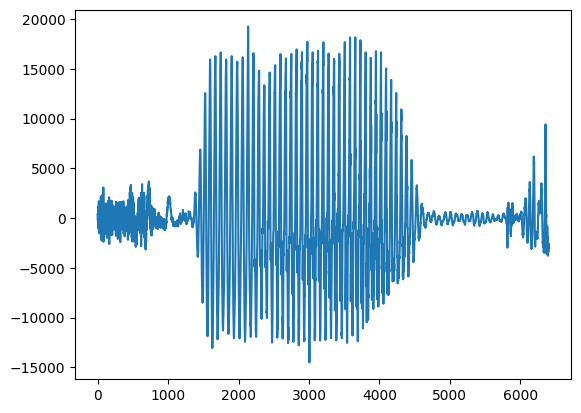

In [16]:
word, word_audio = clip_word('snake', paired_with_timestamps, sample[1])
no_context_transcription, _ = transcribe_batch_timestamped([(word, word_audio)], model, processor)
show_sample((no_context_transcription, word_audio))


IPA: ['s n e k']


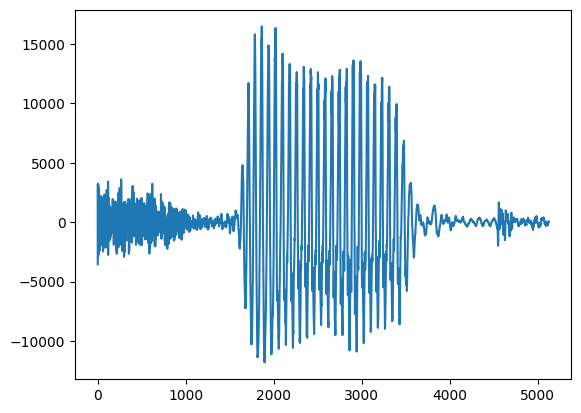

In [17]:
word, word_audio = clip_word('snack', paired_with_timestamps, sample[1])
no_context_transcription, _ = transcribe_batch_timestamped([(word, word_audio)], model, processor)
show_sample((no_context_transcription, word_audio))

IPA: ['ɪ n s t æ']


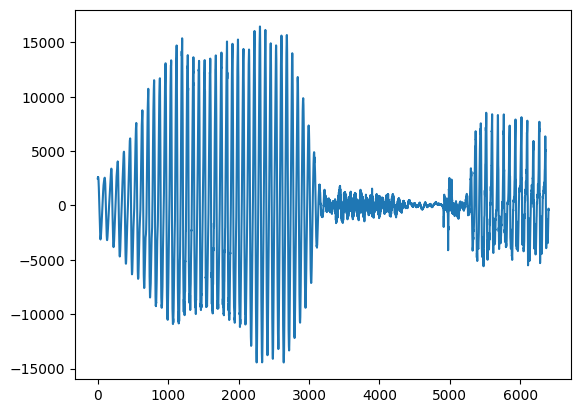

In [18]:
word, word_audio = clip_word('Wednesday', paired_with_timestamps, sample[1])
no_context_transcription, _ = transcribe_batch_timestamped([(word, word_audio)], model, processor)
show_sample((no_context_transcription, word_audio))

# Run on all data

In [33]:
data = {
    'full_audio': [],
    'snake_audio': [],
    'snack_audio': [],
    'bags_audio': [],
    'snake_incontext_transcription': [],
    'snack_incontext_transcription': [],
    'bags_incontext_transcription': [],
    'snake_nocontext_transcription': [],
    'snack_nocontext_transcription': [],
    'bags_nocontext_transcription': [],
    'full_facebook_transcription': [],
    'age' : [],
    'birthplace' : [],
    'native_language' : [],
    'sex': [],
    'country': [],
    'speakerid': [],
}
speaker_info = speakers[speakers['file_missing?'] == False].reset_index(drop=True)[['age', 'birthplace', 'native_language', 'sex', 'country', 'speakerid']]

for i in range(len(RECORDINGS)):
    torch.mps.empty_cache()
    sample = get_sample(i)
    transcription, timestamped_phonemes = transcribe_batch_timestamped([sample], model, processor)
    paired_with_timestamps = pair_by_word_with_timestamps(timestamped_phonemes[0])
    full_audio = sample[1]
    path = os.path.abspath(os.path.join('..', 'data', 'speech-accent-context'))
    full_audio_path = os.path.join(path, f'{i}_full.wav')
    audio_array_to_wav_file(full_audio, full_audio_path)
    data['full_audio'].append(full_audio_path)
    data['full_facebook_transcription'].append(transcription[0])
    for word in ['snake', 'snack', 'bags']:
        paired_ipa, word_audio = clip_word(word, paired_with_timestamps, full_audio)
        no_context_transcription, _ = transcribe_batch_timestamped([(word, word_audio)], model, processor)
        word_audio_path = os.path.join(path, f'{i}_{word}.wav')
        audio_array_to_wav_file(word_audio, word_audio_path)
        data[f'{word}_audio'].append(word_audio_path)
        data[f'{word}_incontext_transcription'].append(''.join(s for t, s, _ in paired_ipa))
        data[f'{word}_nocontext_transcription'].append(simplify_ipa(no_context_transcription[0]))
    speaker_info_row = speaker_info.iloc[i]
    data['age'].append(speaker_info_row['age'])
    data['birthplace'].append(speaker_info_row['birthplace'])
    data['native_language'].append(speaker_info_row['native_language'])
    data['sex'].append(speaker_info_row['sex'])
    data['country'].append(speaker_info_row['country'])
    data['speakerid'].append(speaker_info_row['speakerid'])
    with open(os.path.join(path, f'{i}.txt'), 'w') as f:
        f.write(f'TEXT: {text}\n')
        f.write(f'TRANSCRIPTION: {transcription[0]}\n')
        f.write(f'\n')
        for word in ['snake', 'snack', 'bags']:
            f.write(f'{word.upper()} INCONTEXT: {data[f"{word}_incontext_transcription"][-1]}\n')
            f.write(f'{word.upper()} NOCONTEXT: {data[f"{word}_nocontext_transcription"][-1]}\n')
        f.write(f'\n')
        f.write(f'SPEAKER INFO: {speaker_info_row.to_dict()}\n')
        f.write(f'\n')
        f.write(f'G2P ALIGNMENT: {paired_with_timestamps}\n')

In [88]:
from datasets import Dataset, Audio
data['age'] = list(map(int, data['age']))
data['speakerid'] = list(map(int, data['speakerid']))
data['birthplace'] = list(map(str, data['birthplace']))
data['country'] = list(map(str, data['country']))
audio_dataset = Dataset.from_dict(data)
for col in data.keys():
    if 'audio' in col:
        print(f'Casting {col} to Audio')
        audio_dataset = audio_dataset.cast_column(col, Audio())

Casting full_audio to Audio
Casting snake_audio to Audio
Casting snack_audio to Audio
Casting bags_audio to Audio


In [89]:
audio_dataset.push_to_hub('KoelLabs/speech-accent-context')
clear_output()

In [59]:
SNACK_G2P = 'snæk'
SNAKE_G2P = 'sneɪk'
BAGS_G2P = 'bæɡz'

In [62]:
df = pd.DataFrame(data)
incontext_snake_not_match_nocontext = df[df['snake_incontext_transcription'] != df['snake_nocontext_transcription']]
print(len(incontext_snake_not_match_nocontext))
incontext_is_g2p_snake = incontext_snake_not_match_nocontext[incontext_snake_not_match_nocontext['snake_incontext_transcription'] == SNAKE_G2P]
print(len(incontext_is_g2p_snake))
print(len(incontext_is_g2p_snake) / len(incontext_snake_not_match_nocontext))

1205
809
0.6713692946058091


In [71]:
from IPython.display import Audio, display

def show_word_sample(row, word='snake'):
    print("G2P", simplify_ipa(text2ipa(word)))
    print("IN-CONTEXT", row['snake_incontext_transcription'])
    print("NO-CONTEXT", row['snake_nocontext_transcription'])
    display(Audio(row[f'{word}_audio']['path']))
    display(Audio(row['full_audio']['path']))
    print("GENDER", row['sex'])
    print("AGE", row['age'])
    print("NATIVE LANGUAGE", row['native_language'])
    print("BIRTHPLACE", row['birthplace'])
    print("COUNTRY", row['country'])

In [72]:
show_word_sample(incontext_is_g2p_snake.iloc[0])

G2P sneɪk
IN-CONTEXT sneɪk
NO-CONTEXT snaɪk


GENDER female
AGE 27
NATIVE LANGUAGE afrikaans
BIRTHPLACE virginia, south africa
COUNTRY south africa
